In [319]:
import pandas as pd
import numpy as np
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
import matplotlib.pyplot as plt
from random import randrange

In [272]:
dat_fin = pd.read_csv("total_final_merge.csv")
dat_fin.fillna(0, inplace = True)
dat_fin = dat_fin.drop(["salerevenuerub", "promo_per_pcs"], axis = 1)
dat_fin["prev"] = np.array([False]+[(dat_fin.iloc[i-1,5]!= 0) \
                                    & (dat_fin.iloc[i,5]!= 0) for i in range(1,len(dat_fin))]).astype(int)
dat_fin.sale_dt = pd.to_datetime(dat_fin.sale_dt)
dat_fin["month"] = dat_fin.sale_dt.apply(lambda x: x.month)
dat_fin = dat_fin.drop(["sale_dt", "soldpieces"], axis = 1)

In [274]:
dat_fin.head()

,skutertiaryid,chaindiscountvalue,promo_cost,sales_groth,prev,month
0,7182,0.0,0,0.0,0,1
1,7182,0.0,0,0.0,0,1
2,7182,0.0,0,0.0,0,1
3,7182,0.0,0,0.0,0,1
4,7182,0.0,0,0.0,0,2


In [317]:
mse_arr = []
model = RandomForestRegressor(n_estimators= 300)
tmp_df = dat_fin.drop(["skutertiaryid"], axis = 1)[dat_fin.sales_groth != 0]
X = tmp_df[["promo_cost", "month"]].values#tmp_df[["chaindiscountvalue", "promo_cost", "prev", "month"]].values
Y = tmp_df[["sales_groth"]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle = True)
scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)
Y_pred = model.fit(X_train, Y_train).predict(X_test)
#Y_pred2 = gpr.fit(X_train, Y_train).predict(X_test)
mse_arr.append([mean_squared_error(Y_pred, Y_test, squared= False)])#, mean_squared_error(Y_pred2, Y_test, squared= False)])
print(f"Model fitted parameters are: {model.feature_importances_} \nRMSE:{mse_arr[0]}, \
\nMAE:{mean_absolute_error(Y_pred, Y_test)}")

<ipython-input-317-805cd8aeaaad>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Y_pred = model.fit(X_train, Y_train).predict(X_test)


Model fitted parameters are: [0.7388997 0.2611003] 
RMSE:[50300.15284998413], 
MAE:30697.470175438597


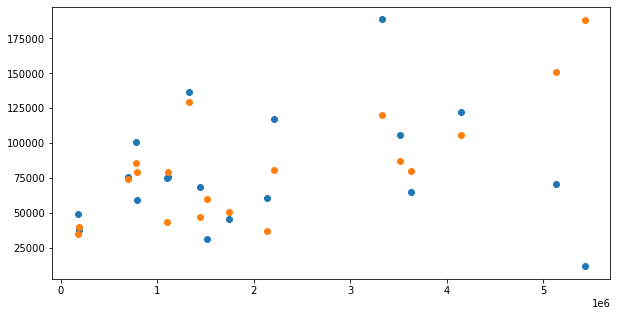

In [318]:
plt.figure(figsize=(10,5))
plt.scatter(X_test[:,0],Y_test)
plt.scatter(X_test[:,0],Y_pred)

In [502]:
class PromoVector:
    def __init__(self, cash, estimator):
        self.cash = cash
        self.months = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        self.estimator = estimator
        #self.prev_part = []
    
    def random_partition(self, n, s):
        partition = [0] * s
        for x in range(n):
            partition[random.randrange(s)] += 1
        return np.array(partition)
    
    def mutate(self):
        ###Step 1 - mutate random month
        r = randrange(12)
        self.months[r] = self.months[r]^1
        #print(self.cash,int(sum(self.months)))
        money_vec = np.zeros_like(self.months)
        money_vec[np.where(self.months == 1)] = self.random_partition(self.cash, int(sum(self.months)))
        #print(money_vec)
        X = np.hstack((money_vec.reshape(-1,1), self.months.reshape(-1,1)))
        Y_pred = self.estimator.predict(X[self.months!=0,:])
        total_win = Y_pred.sum()
        return (total_win, X, Y_pred) 
            

In [503]:
a = PromoVector(120000, model)

In [511]:
a.mutate()

(61558.77333333333,
 array([[    0,     0],
        [    0,     0],
        [    0,     0],
        [29886,     1],
        [    0,     0],
        [    0,     0],
        [29962,     1],
        [    0,     0],
        [    0,     0],
        [30057,     1],
        [    0,     0],
        [30095,     1]]),
 array([15389.69333333, 15389.69333333, 15389.69333333, 15389.69333333]))